# Introduction
In the last two decades, E-commerce is becoming wildly popular. Out of the many E-commerce stores, Amazon is capturing a lot of the market share. For instance, in 2021, Amazon has > 450 billion USD in revenue. Up to 2021, Amazon's year on year gross revenue has been increasing. One of the ways of increasing revenue in an E-commerce store is to make sure that the customer gets recommended a highly relevant product out of the noisy marketplace. A basic customer journey starts from opening a browser or mobile app, then signing in, followed by browsing products, adding to cart, and finally checking out. This project focuses on recommending the most relevant products.

Common types of filtering techniques include collaborative, content-based, demographic, utility, knowledge-based, and hybrid recommender systems.

A raw dataset is taken from Kaggle. The data contains 497,577 rows of ratings of Amazon's Video Game category.

In [2]:
#Read in the raw data and store as a dataframe
import pandas as pd
import numpy as np
df = pd.read_json('video_games_dataset.json',lines=True)
pd.set_option("display.max.columns", None)
df.head()

import warnings
warnings.filterwarnings('ignore')

To ensure that the review text is a string that can be processed by NLP techniques, we change the data type to a string.

In [4]:
#Set column type
df['reviewText'] = df['reviewText'].astype("string")

# Data Understanding
- Check whether empty rows exist: They do.

In [6]:
df.loc[df['reviewText'].isnull()].isnull().sum()

overall             0
verified            0
reviewTime          0
reviewerID          0
asin                0
reviewerName        0
reviewText        158
summary             6
unixReviewTime      0
vote              149
style              44
image             124
dtype: int64

### Store reviews text in a separate DataFrame

In [7]:
reviews_df = df.groupby('reviewerID')['reviewText'].unique().str.join(' ').reset_index()

### Remove empty rows

In [8]:
# Remove empty rows from reviews_text
reviews_df.dropna(
    axis=0,
    how='any',
    thresh=None,
    subset=None,
    inplace=True
)

### Reduce data size due to computational restrictions - we take the first 25,000 rows of data

In [11]:
# reduce data size due to computational restrictions
reviews_df['reviewText'] = reviews_df['reviewText'].astype("string")
reduced_reviews_df = reviews_df.iloc[0:25000]
reduced_reviews_df

,reviewerID,reviewText
0,A0059486XI1Z0P98KP35,"This game is just incredible, and a must-have ..."
1,A0220159ZRNBTRKLG08H,Im still not sure why my son plays the old gam...
2,A0266076X6KPZ6CCHGVS,Very satisfied customer! This game is awesome ...
3,A0277912HT4JSJKVSL3E,This game is cool but i hate the fact that you...
4,A02836981FYG9912C66F,It seems to be a good mouse but I have medium ...
...,...,...
25024,A2PT8P1A6VFHQC,My First Mouse from razer. the middle scroll w...
25025,A2PT9EOW0Z6DLM,"Splinter cell is awesome game,very good graphi..."
25026,A2PTCBGX667A2R,played for 5 min then pinched myself to try to...
25027,A2PTCR39FH9GLM,Underrated Classic Best persona game in my opi...


(array([ 30883.,      0.,  24135.,      0.,      0.,  49146.,      0.,
         93654.,      0., 299759.]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]),
 <BarContainer object of 10 artists>)

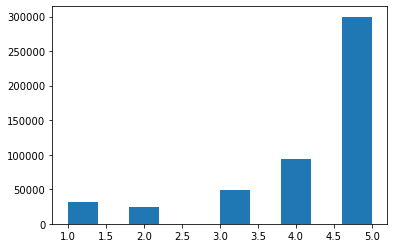

In [12]:
import matplotlib.pyplot as plt
plt.hist(df['overall'])

### We can see that majority of the ratings are above 4.5, meaning many of our product recommendations will be based on popular items.

In [25]:
import nltk
nltk.download('omw-1.4')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
wordnet_lem = WordNetLemmatizer()

from nltk.corpus import stopwords
nltk.download('stopwords')
stopwords_vocab = stopwords.words('english')

VERB_CODES = {'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ'}

def preprocess(text):
    # lower case text
    text = text.lower()
    temp_list = []
    # tokenization
    words = nltk.word_tokenize(text)
    # pos tagging for each token
    tags = nltk.pos_tag(words)
    for i, word in enumerate(words):
        if tags[i][1] in VERB_CODES:
            lemmatized = wordnet_lem.lemmatize(word, 'v')
        else:
            lemmatized = wordnet_lem.lemmatize(word)
        if lemmatized not in stopwords_vocab and lemmatized.isalpha():
            temp_list.append(lemmatized)
          
    finalString = ' '.join(temp_list)
    finalString = finalString.replace("n't", " not")
    finalString = finalString.replace("'m", " am")
    finalString = finalString.replace("'s", " is")
    finalString = finalString.replace("'re", " are")
    finalString = finalString.replace("'ll", " will")
    finalString = finalString.replace("'ve", " have")
    finalString = finalString.replace("'d", " would")
    finalString = finalString.replace("\n", "")
    return finalString

reduced_reviews_df['preprocessed']= reduced_reviews_df['reviewText'].apply(preprocess)
reduced_reviews_df['preprocessed'].head()

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\gavin\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\gavin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\gavin\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\gavin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gavin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


0    game incredible smt fan strategy jrpg good one...
1    im still sure son play old game cube love game...
2    satisfied customer game awesome get christmas ...
3    game cool hate fact online order play fell lov...
4    seem good mouse medium size hand still feel ki...
Name: preprocessed, dtype: object

### Here we do the necessary text preprocessing steps and store the preprocessed text as a column in a DataFrame
Steps are: Lowering of letters, tokenization, lemmatization, removal of stopwords, and the unique replacement of words such as commmon short form words like n't to not.

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\gavin\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


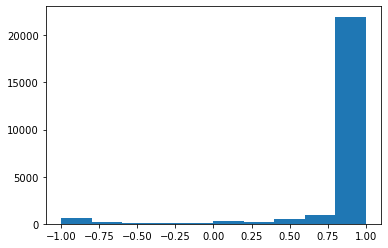

In [26]:
#VADER Sentiment Analysis
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sentiment = SentimentIntensityAnalyzer()
def giveSentimentScore(text):
    return sentiment.polarity_scores(text)['compound']
reduced_reviews_df['sentiment'] = reduced_reviews_df['reviewText'].apply(giveSentimentScore)

import matplotlib.pyplot as plt
fig = plt.hist(reduced_reviews_df['sentiment'])

We can see from the results from VADER Sentiment Analysis that the reviews are mostly positive (majority of our recommendations will contain popular products).


## Vectorize the reviews text

In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer()
dtm = tfidf.fit_transform(reduced_reviews_df['preprocessed'])

## Constructing the Cosine Similarity matrix

In [30]:
# cosine similarity between vectors
from sklearn.metrics.pairwise import cosine_similarity
cosine_sim = cosine_similarity(dtm, dtm)

In [31]:
# Storing indices of the data
indices = pd.Series(reviews_df['reviewerID'])
  
def recommendations(user, cosine_sim = cosine_sim):
    recommmended_users = []
    index = indices[indices == user].index[0]
    similarity_scores = pd.Series(cosine_sim[index]).sort_values(ascending = False)
    top_10_users = list(similarity_scores.iloc[1:11].index)
    for i in top_10_users:
        recommmended_users.append(list(df.index)[i])
    return recommmended_users

## Get recommendation
Based on a given user, we can obtain the top 10 recommendations.

In [32]:
# Get top 10 recommended similar customers for a specific user, i.e. A1HP7NVNPFMA4N
listOfSimCusts = recommendations('A0266076X6KPZ6CCHGVS')

# Get top 10 recommended products
for i in listOfSimCusts:
    print(df.loc[i]['asin'])

B00004W4QV
B00004SVYE
B00002SX0E
B00004SVYQ
B00000J2W7
B00002SUAD
B0000503MO
B00004TBGT
B00001XDK5
B00002STYC


## Conclusion
Further steps can be taken to take into account the accuracy of this model such as splitting the dataset into train-test data, having a more balanced dataset that contains a more balanced sentiment, as well as adding other supervised/unsupervised learning algorithms in the mix to improve the model accuracy.